In [16]:
import pandas as pd
import numpy as np

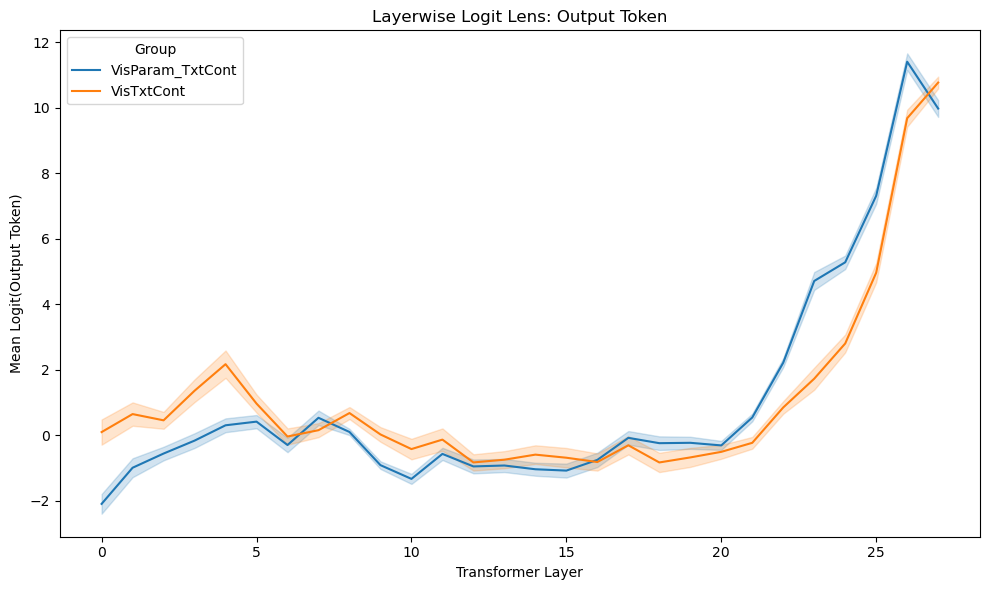

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- path ---
CSV_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens.csv"

df = pd.read_csv(CSV_PATH)
df = df[(df['Group'] == 'VisParam_TxtCont') | (df['Group'] == 'VisTxtCont')]
# Optional: filter to a specific error category
df = df[df["Category"] == "Career_error"]

# Ensure correct ordering
df = df.sort_values(["Group", "Layer"])
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df,
    x="Layer",
    y="Logit_Output",
    hue="Group",
    estimator="mean",
    errorbar="se"
)

plt.title("Layerwise Logit Lens: Output Token")
plt.xlabel("Transformer Layer")
plt.ylabel("Mean Logit(Output Token)")
plt.legend(title="Group")
plt.tight_layout()
plt.show()



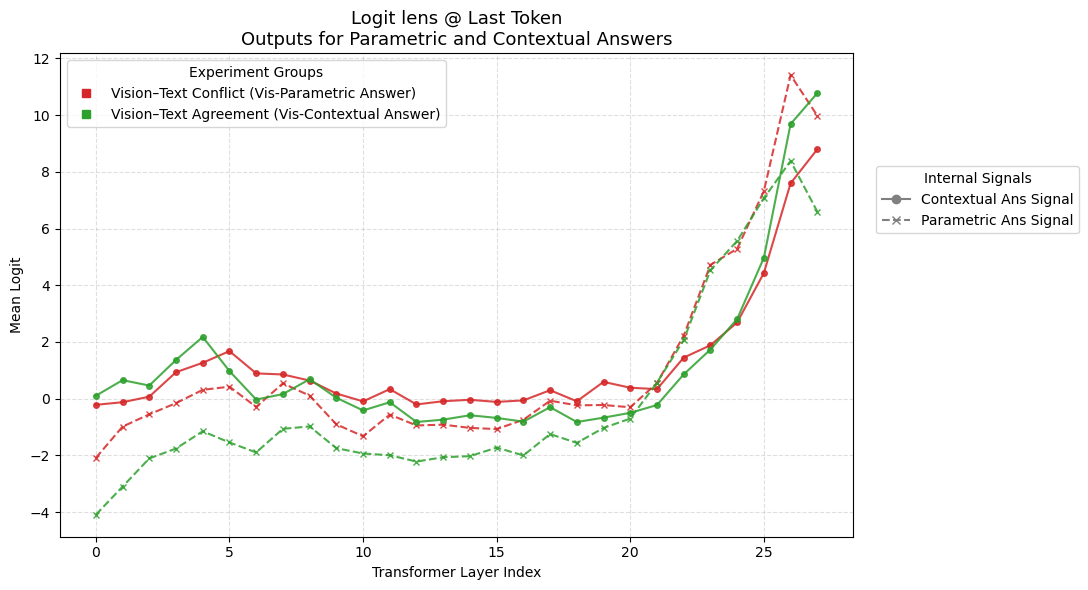

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

# 1) Load + Prepare
CSV_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens.csv"
df = pd.read_csv(CSV_PATH)

df = df[(df['Group'] == 'VisParam_TxtCont') | (df['Group'] == 'VisTxtCont')]
df = df[df["Category"] == "Career_error"]

keep_groups = ['VisParam_TxtCont', 'VisTxtCont']

# --- NEW symmetric stream definitions ---
df["Context_Stream"] = np.where(
    df["Group"] == "VisTxtCont",      # vis_same_text
    df["Logit_Output"],               # use output as contextual signal
    df["Logit_Context"],              # otherwise normal contextual logit
)

df["Parametric_Stream"] = np.where(
    df["Group"] == "VisParam_TxtCont",  # vis_diff_text
    df["Logit_Output"],                 # use output as parametric signal
    df["Logit_Parametric"],             # otherwise normal parametric logit
)

# Aggregate across items
df_avg = (
    df.groupby(["Group", "Layer"])[["Context_Stream", "Parametric_Stream"]]
      .mean()
      .reset_index()
)

group_map = {
    "VisParam_TxtCont": "Vision–Text Conflict (Vis-Parametric Answer)",
    "VisTxtCont": "Vision–Text Agreement (Vis-Contextual Answer)",
}

metric_map = {
    "Context_Stream": "Contextual Stream",
    "Parametric_Stream": "Parametric Stream",
}

# 2) Plot
plt.figure(figsize=(11, 6))

groups = [g for g in keep_groups if g in df_avg["Group"].unique()]
colors = ['#d62728', '#2ca02c']

for i, group in enumerate(groups):
    subset = df_avg[df_avg["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]

    # Context (solid)
    plt.plot(
        subset["Layer"], subset["Context_Stream"],
        color=color, linestyle="-", marker="o",
        alpha=0.85, markersize=4
    )

    # Parametric (dashed)
    plt.plot(
        subset["Layer"], subset["Parametric_Stream"],
        color=color, linestyle="--", marker="x",
        alpha=0.85, markersize=5
    )

# 3) Legends
group_handles = [
    mlines.Line2D([], [], color=colors[i], marker="s", linestyle="None",
                  label=group_map.get(g, g))
    for i, g in enumerate(groups)
]

metric_handles = [
    mlines.Line2D([], [], color="gray", linestyle="-", marker="o",
                  label="Contextual Ans Signal"),
    mlines.Line2D([], [], color="gray", linestyle="--", marker="x",
                  label="Parametric Ans Signal"),
]

first_legend = plt.legend(
    handles=group_handles, title="Experiment Groups",
    loc="upper left", #bbox_to_anchor=(0.80, 0.2)
)
plt.gca().add_artist(first_legend)

plt.legend(
    handles=metric_handles, title="Internal Signals",
    loc="upper left", bbox_to_anchor=(1.02, 0.78)
)

plt.title(
    "Logit lens @ Last Token\n"
    "Outputs for Parametric and Contextual Answers",
    fontsize=13
)
plt.xlabel("Transformer Layer Index")
plt.ylabel("Mean Logit")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


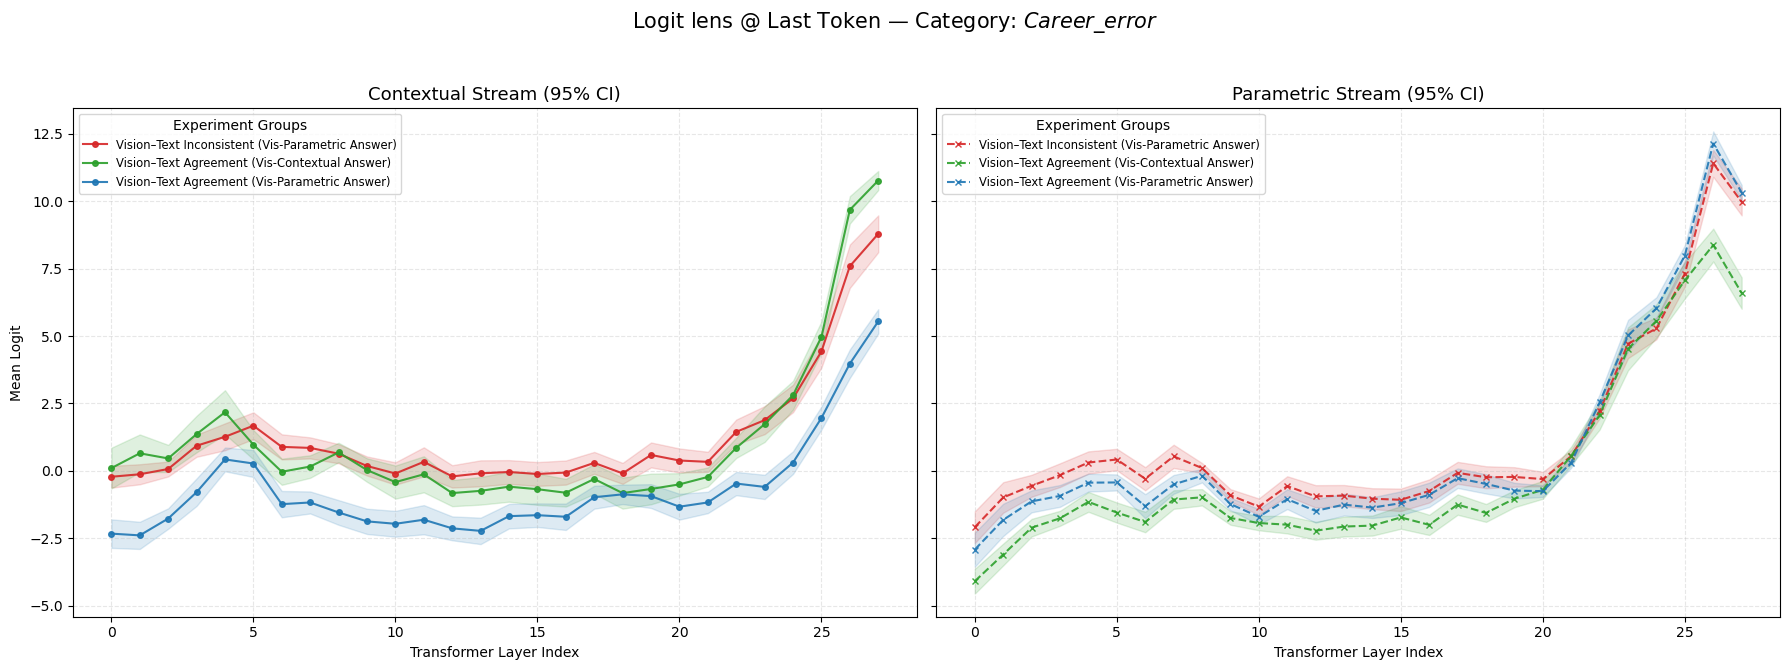

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Load + Prepare
CSV_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens.csv"
df = pd.read_csv(CSV_PATH)

# Define and filter groups
keep_groups = ['VisParam_TxtCont', 'VisTxtCont', 'VisTxtParam']
df = df[df['Group'].isin(keep_groups)]
df = df[df["Category"] == "Career_error"]

# --- NEW symmetric stream definitions ---
df["Context_Stream"] = np.where(
    df["Group"] == "VisTxtCont",      # vis_same_text
    df["Logit_Output"],               # use output as contextual signal
    df["Logit_Context"],              # otherwise normal contextual logit
)

df["Parametric_Stream"] = np.where(
    (df["Group"].isin(["VisParam_TxtCont", "VisTxtParam"])),  # vis_diff_text
    df["Logit_Output"],                 # use output as parametric signal
    df["Logit_Parametric"],             # otherwise normal parametric logit
)

# 2) Aggregate stats for Mean and CI calculation
# We calculate mean, std, and count to compute the 95% CI manually
df_stats = df.groupby(["Group", "Layer"]).agg({
    "Context_Stream": ["mean", "std", "count"],
    "Parametric_Stream": ["mean", "std", "count"]
}).reset_index()

# Flatten multi-index columns for easier access
df_stats.columns = ["Group", "Layer", 
                   "Context_mean", "Context_std", "Context_count", 
                   "Parametric_mean", "Parametric_std", "Parametric_count"]

# Compute 95% Confidence Interval: 1.96 * (std / sqrt(n))
def calculate_ci(std, count):
    return 1.96 * (std / np.sqrt(count))

df_stats["Context_CI"] = calculate_ci(df_stats["Context_std"], df_stats["Context_count"])
df_stats["Parametric_CI"] = calculate_ci(df_stats["Parametric_std"], df_stats["Parametric_count"])

group_map = {
    "VisParam_TxtCont": "Vision–Text Inconsistent (Vis-Parametric Answer)",
    "VisTxtCont": "Vision–Text Agreement (Vis-Contextual Answer)",
    "VisTxtParam": "Vision–Text Agreement (Vis-Parametric Answer)"
}

colors = ['#d62728', '#2ca02c', '#1f77b4']

# ===== Side-by-Side Plots with Shared Y-Axis and CIs =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# 2A) Contextual Stream plot (Left)
for i, group in enumerate(keep_groups):
    subset = df_stats[df_stats["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]
    
    # Plot mean line
    ax1.plot(
        subset["Layer"], subset["Context_mean"],
        color=color, linestyle="-", marker="o",
        alpha=0.9, markersize=4,
        label=group_map.get(group, group),
    )
    # Plot CI shadow
    ax1.fill_between(
        subset["Layer"], 
        subset["Context_mean"] - subset["Context_CI"], 
        subset["Context_mean"] + subset["Context_CI"], 
        color=color, alpha=0.15  # Adjust alpha for transparency
    )

ax1.set_title("Contextual Stream (95% CI)", fontsize=13)
ax1.set_xlabel("Transformer Layer Index")
ax1.set_ylabel("Mean Logit")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.legend(title="Experiment Groups", loc="upper left", fontsize='small')

# 2B) Parametric Stream plot (Right)
for i, group in enumerate(keep_groups):
    subset = df_stats[df_stats["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]
    
    # Plot mean line
    ax2.plot(
        subset["Layer"], subset["Parametric_mean"],
        color=color, linestyle="--", marker="x",
        alpha=0.9, markersize=5,
        label=group_map.get(group, group),
    )
    # Plot CI shadow
    ax2.fill_between(
        subset["Layer"], 
        subset["Parametric_mean"] - subset["Parametric_CI"], 
        subset["Parametric_mean"] + subset["Parametric_CI"], 
        color=color, alpha=0.15
    )

ax2.set_title("Parametric Stream (95% CI)", fontsize=13)
ax2.set_xlabel("Transformer Layer Index")
ax2.grid(True, linestyle="--", alpha=0.3)
ax2.legend(title="Experiment Groups", loc="upper left", fontsize='small')

# Global figure formatting
plt.suptitle("Logit lens @ Last Token — Category: $Career\_error$", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

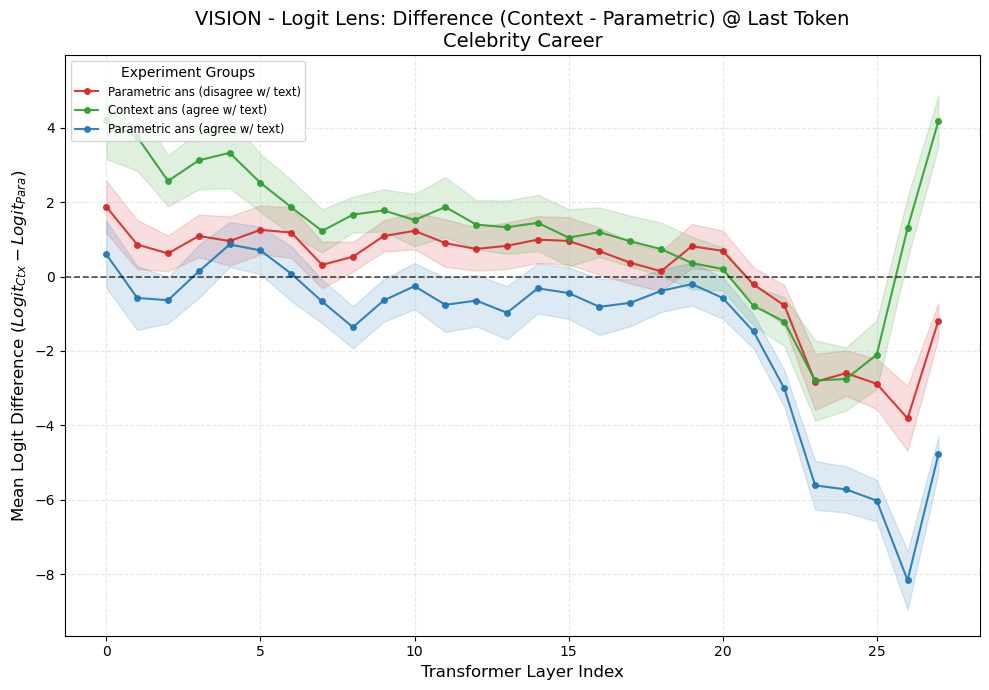

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Load + Prepare
CSV_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens.csv"
df = pd.read_csv(CSV_PATH)

# Define and filter groups
keep_groups = ['VisParam_TxtCont', 'VisTxtCont', 'VisTxtParam']
df = df[df['Group'].isin(keep_groups)]
df = df[df["Category"] == "Career_error"]

# --- Symmetric stream definitions ---
df["Context_Stream"] = np.where(
    df["Group"] == "VisTxtCont",      # vis_same_text
    df["Logit_Output"],               # use output as contextual signal
    df["Logit_Context"],              # otherwise normal contextual logit
)

df["Parametric_Stream"] = np.where(
    (df["Group"].isin(["VisParam_TxtCont", "VisTxtParam"])),  
    df["Logit_Output"],                 
    df["Logit_Parametric"],             
)


df["Stream_Diff"] = df["Context_Stream"] - df["Parametric_Stream"]

df_stats = df.groupby(["Group", "Layer"]).agg({
    "Stream_Diff": ["mean", "std", "count"]
}).reset_index()

# Flatten multi-index columns
df_stats.columns = ["Group", "Layer", "Diff_mean", "Diff_std", "Diff_count"]

# Compute 95% Confidence Interval: 1.96 * (std / sqrt(n))
def calculate_ci(std, count):
    return 1.96 * (std / np.sqrt(count))

df_stats["Diff_CI"] = calculate_ci(df_stats["Diff_std"], df_stats["Diff_count"])

group_map = {
    "VisParam_TxtCont": "Parametric ans (disagree w/ text)",
    "VisTxtCont": "Context ans (agree w/ text)",
    "VisTxtParam": "Parametric ans (agree w/ text)"
}

colors = ['#d62728', '#2ca02c', '#1f77b4']

# ===== Plotting the Difference =====
plt.figure(figsize=(10, 7))

for i, group in enumerate(keep_groups):
    subset = df_stats[df_stats["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]
    
    # Plot mean line
    plt.plot(
        subset["Layer"], subset["Diff_mean"],
        color=color, linestyle="-", marker="o",
        alpha=0.9, markersize=4,
        label=group_map.get(group, group),
    )
    # Plot CI shadow
    plt.fill_between(
        subset["Layer"], 
        subset["Diff_mean"] - subset["Diff_CI"], 
        subset["Diff_mean"] + subset["Diff_CI"], 
        color=color, alpha=0.15
    )


plt.axhline(0, color='black', linestyle='--', linewidth=1.2, alpha=0.7)


plt.title("VISION - Logit Lens: Difference (Context - Parametric) @ Last Token\nCelebrity Career", fontsize=14)
plt.xlabel("Transformer Layer Index", fontsize=12)
plt.ylabel("Mean Logit Difference ($Logit_{Ctx} - Logit_{Para}$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Experiment Groups", loc="upper left", fontsize='small')

plt.tight_layout()
plt.show()

In [21]:
CSV_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens.csv"
df = pd.read_csv(CSV_PATH)
df['Group'].value_counts() / 28

Group
VisTxtCont          249.0
VisTxtParam         161.0
VisParam_TxtCont    103.0
VisCont_TxtParam     12.0
Name: count, dtype: float64

# Entity max logit lens

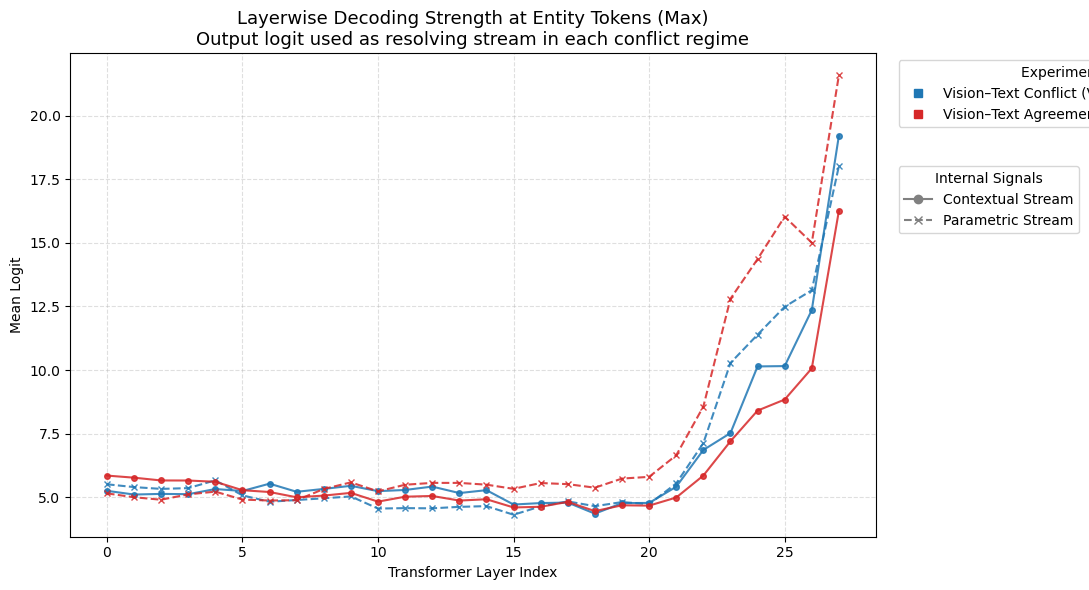

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

# 1) Load + Prepare
CSV_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-entity_tok_LogitLens.csv"
df = pd.read_csv(CSV_PATH)

df = df[(df['Group'] == 'VisParam_TxtCont') | (df['Group'] == 'VisTxtCont')]
df = df[df["Category"] == "Career_error"]

keep_groups = ['VisParam_TxtCont', 'VisTxtCont']

# --- NEW symmetric stream definitions ---
df["Context_Stream"] = np.where(
    df["Group"] == "VisTxtCont",      # vis_same_text
    df["Logit_Output"],               # use output as contextual signal
    df["Logit_Context"],              # otherwise normal contextual logit
)

df["Parametric_Stream"] = np.where(
    df["Group"] == "VisParam_TxtCont",  # vis_diff_text
    df["Logit_Output"],                 # use output as parametric signal
    df["Logit_Parametric"],             # otherwise normal parametric logit
)

# Aggregate across items
df_avg = (
    df.groupby(["Group", "Layer"])[["Context_Stream", "Parametric_Stream"]]
      .mean()
      .reset_index()
)

group_map = {
    "VisParam_TxtCont": "Vision–Text Conflict (Vis-Parametric Answer)",
    "VisTxtCont": "Vision–Text Agreement (Vis-Contextual Answer)",
}

metric_map = {
    "Context_Stream": "Contextual Stream",
    "Parametric_Stream": "Parametric Stream",
}

# 2) Plot
plt.figure(figsize=(11, 6))

groups = [g for g in keep_groups if g in df_avg["Group"].unique()]
colors = ["#1f77b4", "#d62728"]

for i, group in enumerate(groups):
    subset = df_avg[df_avg["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]

    # Context (solid)
    plt.plot(
        subset["Layer"], subset["Context_Stream"],
        color=color, linestyle="-", marker="o",
        alpha=0.85, markersize=4
    )

    # Parametric (dashed)
    plt.plot(
        subset["Layer"], subset["Parametric_Stream"],
        color=color, linestyle="--", marker="x",
        alpha=0.85, markersize=5
    )

# 3) Legends
group_handles = [
    mlines.Line2D([], [], color=colors[i], marker="s", linestyle="None",
                  label=group_map.get(g, g))
    for i, g in enumerate(groups)
]

metric_handles = [
    mlines.Line2D([], [], color="gray", linestyle="-", marker="o",
                  label="Contextual Stream"),
    mlines.Line2D([], [], color="gray", linestyle="--", marker="x",
                  label="Parametric Stream"),
]

first_legend = plt.legend(
    handles=group_handles, title="Experiment Groups",
    loc="upper left", bbox_to_anchor=(1.02, 1)
)
plt.gca().add_artist(first_legend)

plt.legend(
    handles=metric_handles, title="Internal Signals",
    loc="upper left", bbox_to_anchor=(1.02, 0.78)
)

plt.title(
    "Layerwise Decoding Strength at Entity Tokens (Max)\n"
    "Output logit used as resolving stream in each conflict regime",
    fontsize=13
)
plt.xlabel("Transformer Layer Index")
plt.ylabel("Mean Logit")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
#plt.ylim(None, 7.5)
plt.show()


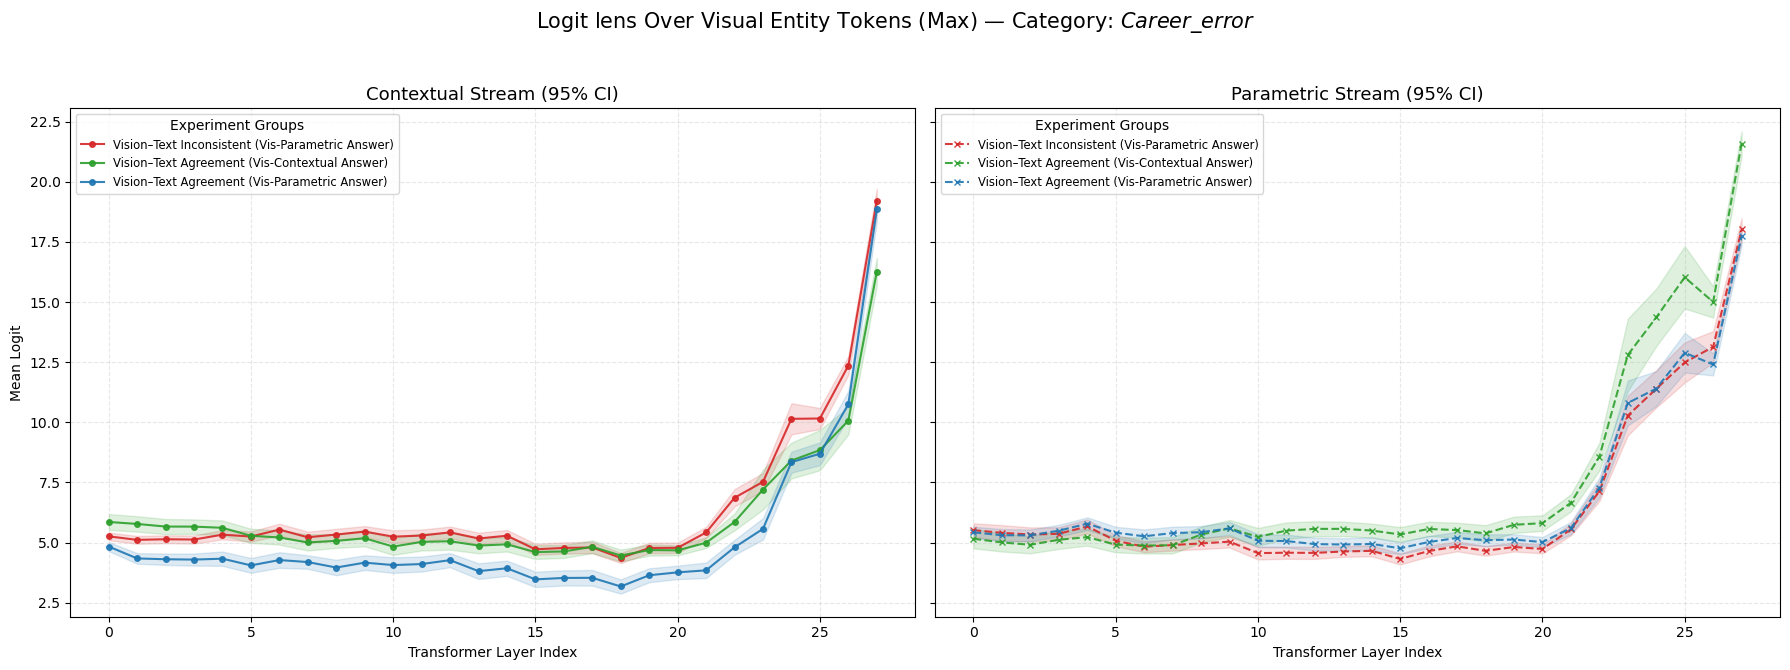

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Load + Prepare
CSV_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-entity_tok_LogitLens.csv"
df = pd.read_csv(CSV_PATH)

# Define and filter groups
keep_groups = ['VisParam_TxtCont', 'VisTxtCont', 'VisTxtParam']
df = df[df['Group'].isin(keep_groups)]
df = df[df["Category"] == "Career_error"]

# --- NEW symmetric stream definitions ---
df["Context_Stream"] = np.where(
    df["Group"] == "VisTxtCont",      # vis_same_text
    df["Logit_Output"],               # use output as contextual signal
    df["Logit_Context"],              # otherwise normal contextual logit
)

df["Parametric_Stream"] = np.where(
    (df["Group"].isin(["VisParam_TxtCont", "VisTxtParam"])),  # vis_diff_text
    df["Logit_Output"],                 # use output as parametric signal
    df["Logit_Parametric"],             # otherwise normal parametric logit
)

# 2) Aggregate stats for Mean and CI calculation
# We calculate mean, std, and count to compute the 95% CI manually
df_stats = df.groupby(["Group", "Layer"]).agg({
    "Context_Stream": ["mean", "std", "count"],
    "Parametric_Stream": ["mean", "std", "count"]
}).reset_index()

# Flatten multi-index columns for easier access
df_stats.columns = ["Group", "Layer", 
                   "Context_mean", "Context_std", "Context_count", 
                   "Parametric_mean", "Parametric_std", "Parametric_count"]

# Compute 95% Confidence Interval: 1.96 * (std / sqrt(n))
def calculate_ci(std, count):
    return 1.96 * (std / np.sqrt(count))

df_stats["Context_CI"] = calculate_ci(df_stats["Context_std"], df_stats["Context_count"])
df_stats["Parametric_CI"] = calculate_ci(df_stats["Parametric_std"], df_stats["Parametric_count"])

group_map = {
    "VisParam_TxtCont": "Vision–Text Inconsistent (Vis-Parametric Answer)",
    "VisTxtCont": "Vision–Text Agreement (Vis-Contextual Answer)",
    "VisTxtParam": "Vision–Text Agreement (Vis-Parametric Answer)"
}

colors = ['#d62728', '#2ca02c', '#1f77b4']

# ===== Side-by-Side Plots with Shared Y-Axis and CIs =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# 2A) Contextual Stream plot (Left)
for i, group in enumerate(keep_groups):
    subset = df_stats[df_stats["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]
    
    # Plot mean line
    ax1.plot(
        subset["Layer"], subset["Context_mean"],
        color=color, linestyle="-", marker="o",
        alpha=0.9, markersize=4,
        label=group_map.get(group, group),
    )
    # Plot CI shadow
    ax1.fill_between(
        subset["Layer"], 
        subset["Context_mean"] - subset["Context_CI"], 
        subset["Context_mean"] + subset["Context_CI"], 
        color=color, alpha=0.15  # Adjust alpha for transparency
    )

ax1.set_title("Contextual Stream (95% CI)", fontsize=13)
ax1.set_xlabel("Transformer Layer Index")
ax1.set_ylabel("Mean Logit")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.legend(title="Experiment Groups", loc="upper left", fontsize='small')

# 2B) Parametric Stream plot (Right)
for i, group in enumerate(keep_groups):
    subset = df_stats[df_stats["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]
    
    # Plot mean line
    ax2.plot(
        subset["Layer"], subset["Parametric_mean"],
        color=color, linestyle="--", marker="x",
        alpha=0.9, markersize=5,
        label=group_map.get(group, group),
    )
    # Plot CI shadow
    ax2.fill_between(
        subset["Layer"], 
        subset["Parametric_mean"] - subset["Parametric_CI"], 
        subset["Parametric_mean"] + subset["Parametric_CI"], 
        color=color, alpha=0.15
    )

ax2.set_title("Parametric Stream (95% CI)", fontsize=13)
ax2.set_xlabel("Transformer Layer Index")
ax2.grid(True, linestyle="--", alpha=0.3)
ax2.legend(title="Experiment Groups", loc="upper left", fontsize='small')

# Global figure formatting
plt.suptitle("Logit lens Over Visual Entity Tokens (Max) — Category: $Career\_error$", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

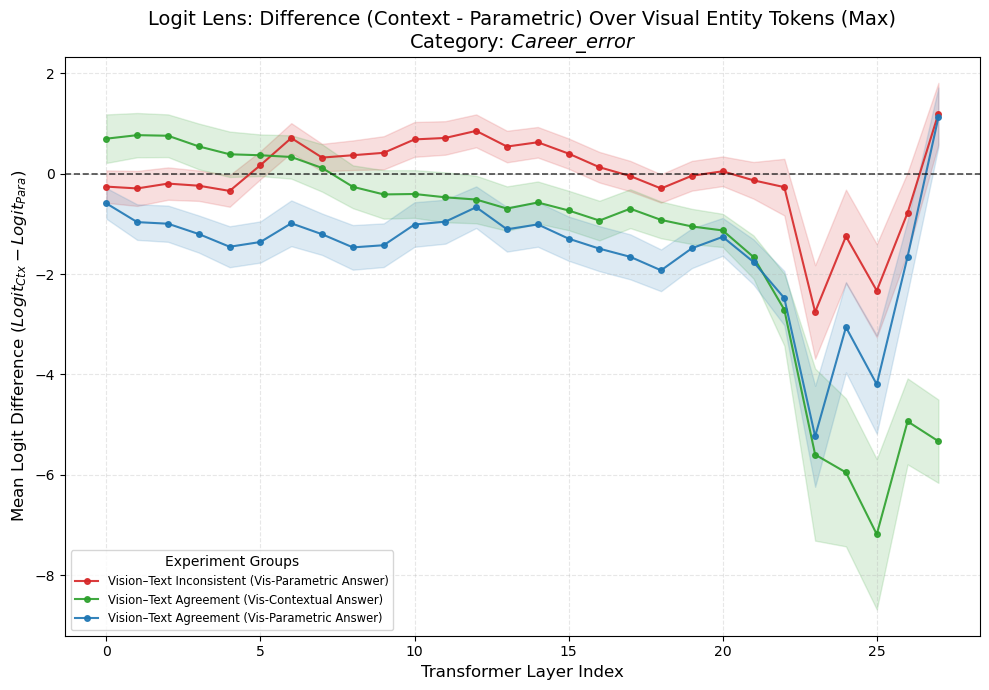

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Load + Prepare
# Note: Ensure the CSV file is in your working directory or update the path accordingly
CSV_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-entity_tok_LogitLens.csv"
df = pd.read_csv(CSV_PATH)

# Define and filter groups
keep_groups = ['VisParam_TxtCont', 'VisTxtCont', 'VisTxtParam']
df = df[df['Group'].isin(keep_groups)]
df = df[df["Category"] == "Career_error"]

# --- Symmetric stream definitions ---
df["Context_Stream"] = np.where(
    df["Group"] == "VisTxtCont",      # vis_same_text
    df["Logit_Output"],               # use output as contextual signal
    df["Logit_Context"],              # otherwise normal contextual logit
)

df["Parametric_Stream"] = np.where(
    (df["Group"].isin(["VisParam_TxtCont", "VisTxtParam"])),  # vis_diff_text
    df["Logit_Output"],                 # use output as parametric signal
    df["Logit_Parametric"],             # otherwise normal parametric logit
)

# --- NEW: Calculate the row-wise difference ---
# Positive = Context bias, Negative = Parametric bias
df["Stream_Diff"] = df["Context_Stream"] - df["Parametric_Stream"]

# 2) Aggregate stats for Mean and CI calculation of the Difference
df_stats = df.groupby(["Group", "Layer"]).agg({
    "Stream_Diff": ["mean", "std", "count"]
}).reset_index()

# Flatten multi-index columns
df_stats.columns = ["Group", "Layer", "Diff_mean", "Diff_std", "Diff_count"]

# Compute 95% Confidence Interval: 1.96 * (std / sqrt(n))
def calculate_ci(std, count):
    return 1.96 * (std / np.sqrt(count))

df_stats["Diff_CI"] = calculate_ci(df_stats["Diff_std"], df_stats["Diff_count"])

group_map = {
    "VisParam_TxtCont": "Vision–Text Inconsistent (Vis-Parametric Answer)",
    "VisTxtCont": "Vision–Text Agreement (Vis-Contextual Answer)",
    "VisTxtParam": "Vision–Text Agreement (Vis-Parametric Answer)"
}

colors = ['#d62728', '#2ca02c', '#1f77b4']

# ===== Plotting the Difference =====
plt.figure(figsize=(10, 7))

for i, group in enumerate(keep_groups):
    subset = df_stats[df_stats["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]
    
    # Plot mean line
    plt.plot(
        subset["Layer"], subset["Diff_mean"],
        color=color, linestyle="-", marker="o",
        alpha=0.9, markersize=4,
        label=group_map.get(group, group),
    )
    # Plot CI shadow
    plt.fill_between(
        subset["Layer"], 
        subset["Diff_mean"] - subset["Diff_CI"], 
        subset["Diff_mean"] + subset["Diff_CI"], 
        color=color, alpha=0.15
    )

# Add a horizontal line at 0 to indicate the point of equality
plt.axhline(0, color='black', linestyle='--', linewidth=1.2, alpha=0.7)

# Formatting
plt.title("Logit Lens: Difference (Context - Parametric) Over Visual Entity Tokens (Max)\nCategory: $Career\_error$", fontsize=14)
plt.xlabel("Transformer Layer Index", fontsize=12)
plt.ylabel("Mean Logit Difference ($Logit_{Ctx} - Logit_{Para}$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Experiment Groups", loc="lower left", fontsize='small')

plt.tight_layout()
plt.show()

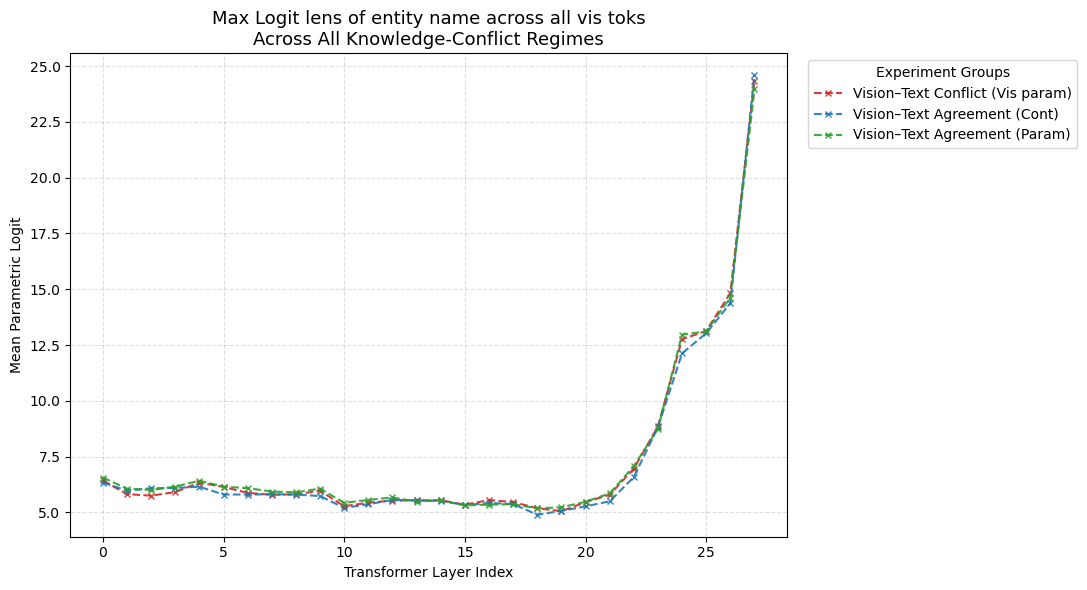

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

# 1) Load
CSV_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-entity_tok_LogitLens.csv"
df = pd.read_csv(CSV_PATH)
df = df[df["Group"] != "VisCont_TxtParam"]
#df = df[df[""]]
# Optional category filter
df = df[df["Category"] == "Career_error"]

# --- symmetric stream definitions (UNCHANGED) ---
df["Context_Stream"] = np.where(
    df["Group"] == "VisTxtCont",
    df["Logit_Output"],
    df["Logit_Context"],
)

df["Parametric_Stream"] = np.where(
    df["Group"] == "VisParam_TxtCont",
    df["Logit_Output"],
    df["Logit_Parametric"],
)

# --- aggregate ---
df_avg = (
    df.groupby(["Group", "Layer"])[["Logit_Entity"]]
      .mean()
      .reset_index()
)

# --- group naming (edit if needed) ---
group_map = {
    "VisParam_TxtCont": "Vision–Text Conflict (Vis param)",
    "VisTxtCont": "Vision–Text Agreement (Cont)",
    "VisCont_TxtParam": "Vision–Text Conflict (Vis Cont)",
    "VisTxtParam": "Vision–Text Agreement (Param)",
}

# --- colors for 4 groups ---
colors = ["#d62728", "#1f77b4", "#2ca02c", "#9467bd"]

groups = sorted(df_avg["Group"].unique())

# 2) Plot
plt.figure(figsize=(11, 6))

for i, group in enumerate(groups):
    subset = df_avg[df_avg["Group"] == group].sort_values("Layer")

    plt.plot(
        subset["Layer"],
        subset["Logit_Entity"],
        color=colors[i % len(colors)],
        linestyle="--",
        marker="x",
        alpha=0.9,
        markersize=5,
        label=group_map.get(group, group),
    )

# 3) Styling
plt.title(
    "Max Logit lens of entity name across all vis toks\n"
    "Across All Knowledge-Conflict Regimes",
    fontsize=13
)
plt.xlabel("Transformer Layer Index")
plt.ylabel("Mean Parametric Logit")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Experiment Groups", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Old logit lens experiment

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# 1) Load + Prepare
OUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens_Grouped.csv"
df = pd.read_csv(OUT_CSV)
df = df[df['Category'] != 'Temporal_error']

# (Optional) keep only groups you care about (and keep ordering stable)
keep_groups = ["VisCorrect_TextWrong", "Others"]
df = df[df["Group"].isin(keep_groups)].copy()

# Aggregate across items: mean logit per layer per group
df_avg = (
    df.groupby(["Group", "Layer"])[["Logit_Context", "Logit_Parametric"]]
      .mean()
      .reset_index()
)

group_map = {
    "VisCorrect_TextWrong": "Vis_diff_text",
    "Others": "Vis_same_text",
}
metric_map = {
    "Logit_Context": "Contextual Signal (Avg logit)",
    "Logit_Parametric": "Parametric Signal (Avg logit)",
}

# 2) Plot
plt.figure(figsize=(11, 6))

# stable group order
groups = [g for g in keep_groups if g in df_avg["Group"].unique()]
colors = ["#1f77b4", "#d62728"]

for i, group in enumerate(groups):
    subset = df_avg[df_avg["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]

    # Context (solid)
    plt.plot(
        subset["Layer"], subset["Logit_Context"],
        color=color, linestyle="-", marker="o",
        alpha=0.85, markersize=4
    )

    # Parametric (dashed)
    plt.plot(
        subset["Layer"], subset["Logit_Parametric"],
        color=color, linestyle="--", marker="x",
        alpha=0.85, markersize=5
    )

# 3) Custom Legends
group_handles = [
    mlines.Line2D([], [], color=colors[i], marker="s", linestyle="None",
                  label=group_map.get(g, g))
    for i, g in enumerate(groups)
]

metric_handles = [
    mlines.Line2D([], [], color="gray", linestyle="-", marker="o",
                  label=metric_map["Logit_Context"]),
    mlines.Line2D([], [], color="gray", linestyle="--", marker="x",
                  label=metric_map["Logit_Parametric"]),
]

first_legend = plt.legend(
    handles=group_handles, title="Experiment Groups",
    loc="upper left", bbox_to_anchor=(1.02, 1)
)
plt.gca().add_artist(first_legend)

plt.legend(
    handles=metric_handles, title="Internal Signals",
    loc="upper left", bbox_to_anchor=(1.02, 0.8)
)

plt.title(
    "Decoding Strength at Last Token (Logit Lens)\n"
    "Avg logit for Context vs Parametric target token",
    fontsize=13
)
plt.xlabel("Transformer Layer Index")
plt.ylabel("Mean Logit")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens_Grouped.csv'

In [27]:
OUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens_Grouped.csv"
df = pd.read_csv(OUT_CSV)
#df = df[df['Category'] == 'Career_error']

# (Optional) keep only groups you care about (and keep ordering stable)
keep_groups = ["VisCorrect_TextWrong", "Others"]
df = df[df["Group"].isin(keep_groups)].copy()
df['Group'].value_counts()/28

Group
Others                  161.0
VisCorrect_TextWrong     70.0
Name: count, dtype: float64

In [29]:
OUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens_Grouped.csv"
df = pd.read_csv(OUT_CSV)
df

,ID,Entity,Category,Group,Layer,Logit_Parametric,Logit_Context,Logit_Diff,TopTokenID,TopToken,TopLogit
0,1,Taylor Swift,Temporal_error,Others,0,0.057892,0.057892,0.000000,121574,樯,11.148438
1,1,Taylor Swift,Temporal_error,Others,1,1.392578,1.392578,0.000000,99396,亲,8.570312
2,1,Taylor Swift,Temporal_error,Others,2,0.116272,0.116272,0.000000,117674,什麽,8.843750
3,1,Taylor Swift,Temporal_error,Others,3,-0.774414,-0.774414,0.000000,146169,∎,10.414062
4,1,Taylor Swift,Temporal_error,Others,4,-1.919922,-1.919922,0.000000,146169,∎,13.195312
...,...,...,...,...,...,...,...,...,...,...,...
6463,149,Lupita Nyong'o,Career_error,VisCorrect_TextWrong,23,6.921875,-4.472656,11.394531,104534,演员,16.671875
6464,149,Lupita Nyong'o,Career_error,VisCorrect_TextWrong,24,7.933594,-2.501953,10.435547,104534,演员,15.171875
6465,149,Lupita Nyong'o,Career_error,VisCorrect_TextWrong,25,8.835938,-1.132812,9.968750,104534,演员,14.523438
6466,149,Lupita Nyong'o,Career_error,VisCorrect_TextWrong,26,10.671875,1.254883,9.416992,104534,演员,14.250000


In [28]:
df[df['Layer'] == 27]['TopToken'].value_counts()

TopToken
1                42
 Canadian        32
 Mexican         31
 actor           16
 Irish           13
 professional    10
 Actress          9
 American         6
 singer           6
 Welsh            5
 chef             4
 French           4
 Scottish         4
 CEO              3
 actress          3
 Australian       2
 New              2
 British          2
 television       2
 Formula          2
 software         2
 Zimbabwe         2
 social           2
 Dominican        1
 journalist       1
 Cuban            1
 Ecuador          1
 Ug               1
 Venezuelan       1
 Cam              1
演员                1
 film             1
 Hong             1
 Chef             1
 Taiwanese        1
 Swiss            1
 German           1
 Bot              1
 Nam              1
 Afghan           1
 athlete          1
 Tennis           1
 tennis           1
 a                1
 Bang             1
 Pakistani        1
 landscape        1
 rapper           1
 South            1
 Ken       

# Logos

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens_Grouped_logo.csv")
df

,ID,Entity,Category,Group,Layer,Logit_Parametric,Logit_Context,Logit_Diff,TopTokenID,TopToken,TopLogit
0,1,Nike,creator_error,Others,0,-0.364258,0.734863,-1.099121,118808,千方百计,9.640625
1,1,Nike,creator_error,Others,1,0.139282,-0.960938,1.100220,15742,ereotype,8.632812
2,1,Nike,creator_error,Others,2,0.996582,-0.271240,1.267822,118228,换句话,11.257812
3,1,Nike,creator_error,Others,3,2.035156,-0.921875,2.957031,14546,�,12.789062
4,1,Nike,creator_error,Others,4,0.103455,-0.528809,0.632263,14546,�,13.882812
...,...,...,...,...,...,...,...,...,...,...,...
5175,74,Meta,content_error,Others,23,3.005859,9.656250,-6.650391,19352,luxury,9.656250
5176,74,Meta,content_error,Others,24,3.527344,9.625000,-6.097656,19352,luxury,9.625000
5177,74,Meta,content_error,Others,25,3.443359,12.054688,-8.611328,19352,luxury,12.054688
5178,74,Meta,content_error,Others,26,5.847656,16.546875,-10.699219,19352,luxury,16.546875


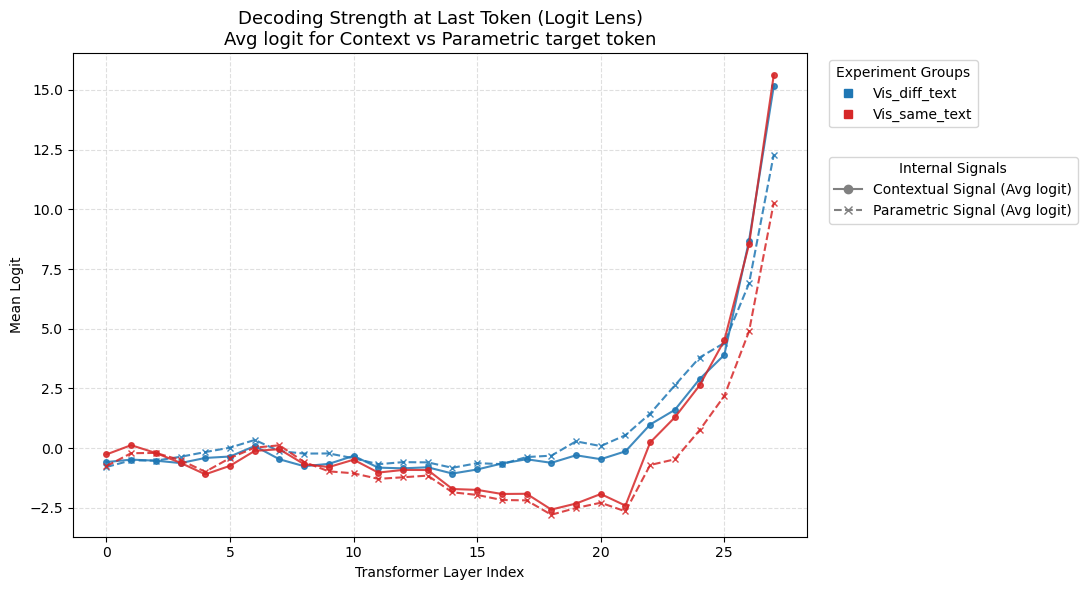

In [16]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/FRQ-Last_tok_LogitLens_Grouped_logo.csv")
#df = df[df['Category'] == 'content_error']

# (Optional) keep only groups you care about (and keep ordering stable)
keep_groups = ["VisCorrect_TextWrong", "Others"]
df = df[df["Group"].isin(keep_groups)].copy()

# Aggregate across items: mean logit per layer per group
df_avg = (
    df.groupby(["Group", "Layer"])[["Logit_Context", "Logit_Parametric"]]
      .mean()
      .reset_index()
)

group_map = {
    "VisCorrect_TextWrong": "Vis_diff_text",
    "Others": "Vis_same_text",
}
metric_map = {
    "Logit_Context": "Contextual Signal (Avg logit)",
    "Logit_Parametric": "Parametric Signal (Avg logit)",
}

# 2) Plot
plt.figure(figsize=(11, 6))

# stable group order
groups = [g for g in keep_groups if g in df_avg["Group"].unique()]
colors = ["#1f77b4", "#d62728"]

for i, group in enumerate(groups):
    subset = df_avg[df_avg["Group"] == group].sort_values("Layer")
    color = colors[i % len(colors)]

    # Context (solid)
    plt.plot(
        subset["Layer"], subset["Logit_Context"],
        color=color, linestyle="-", marker="o",
        alpha=0.85, markersize=4
    )

    # Parametric (dashed)
    plt.plot(
        subset["Layer"], subset["Logit_Parametric"],
        color=color, linestyle="--", marker="x",
        alpha=0.85, markersize=5
    )

# 3) Custom Legends
group_handles = [
    mlines.Line2D([], [], color=colors[i], marker="s", linestyle="None",
                  label=group_map.get(g, g))
    for i, g in enumerate(groups)
]

metric_handles = [
    mlines.Line2D([], [], color="gray", linestyle="-", marker="o",
                  label=metric_map["Logit_Context"]),
    mlines.Line2D([], [], color="gray", linestyle="--", marker="x",
                  label=metric_map["Logit_Parametric"]),
]

first_legend = plt.legend(
    handles=group_handles, title="Experiment Groups",
    loc="upper left", bbox_to_anchor=(1.02, 1)
)
plt.gca().add_artist(first_legend)

plt.legend(
    handles=metric_handles, title="Internal Signals",
    loc="upper left", bbox_to_anchor=(1.02, 0.8)
)

plt.title(
    "Decoding Strength at Last Token (Logit Lens)\n"
    "Avg logit for Context vs Parametric target token",
    fontsize=13
)
plt.xlabel("Transformer Layer Index")
plt.ylabel("Mean Logit")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [18]:
df[df["Layer"] == 27]['TopToken'].value_counts()
df

,ID,Entity,Category,Group,Layer,Logit_Parametric,Logit_Context,Logit_Diff,TopTokenID,TopToken,TopLogit
0,1,Nike,creator_error,Others,0,-0.364258,0.734863,-1.099121,118808,千方百计,9.640625
1,1,Nike,creator_error,Others,1,0.139282,-0.960938,1.100220,15742,ereotype,8.632812
2,1,Nike,creator_error,Others,2,0.996582,-0.271240,1.267822,118228,换句话,11.257812
3,1,Nike,creator_error,Others,3,2.035156,-0.921875,2.957031,14546,�,12.789062
4,1,Nike,creator_error,Others,4,0.103455,-0.528809,0.632263,14546,�,13.882812
...,...,...,...,...,...,...,...,...,...,...,...
5175,74,Meta,content_error,Others,23,3.005859,9.656250,-6.650391,19352,luxury,9.656250
5176,74,Meta,content_error,Others,24,3.527344,9.625000,-6.097656,19352,luxury,9.625000
5177,74,Meta,content_error,Others,25,3.443359,12.054688,-8.611328,19352,luxury,12.054688
5178,74,Meta,content_error,Others,26,5.847656,16.546875,-10.699219,19352,luxury,16.546875
